# Very simple CGAN
This is a simple example based on François Chollet in his book "Deep Learning with Python". We will generate images of cars of 32x32 pixels.

## What is a GAN
A generative Adversarial Networks is a (at least two) series of ML models that competes one against the other.

![GAN learn flow](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2017/09/07/practical_gan_2.gif)

The flow is the following:
1. Create generator model. This model is that will generate the fakes images. It's input is only noise. A simple vector of random values between 0 and 1.+
2. Create the discriminator. This model will clasify images between fakes and real. It's input is the images. It will learn to say if an image is real or not and will give to the generator some info about it, allowing the generator to learn to generate best images.
3. We will link these two models and make the discriminator non trainable. By this way, generator will learn to generate best images.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

First of all we generate the train dataset ensuring each image can be loaded.

In [5]:
from pathlib import Path
from PIL import Image
import glob
import numpy as np
import random

path_base = 'data_processed/filtered/train/happy'
allfiles = [f for f in glob.glob(path_base + "/**/*.jpg", recursive=True)]
random.shuffle(allfiles)

files = []
for i in range(0, len(allfiles)):
    my_file = Path(allfiles[i])
    if my_file.is_file():
        im = Image.open(my_file)
        image = np.array(im)
        if image.ndim == 2:
            files.append(allfiles[i])
        else:
            print(allfiles[i])

# path_base = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test'
# allfiles = [f for f in glob.glob(path_base + "/**/*.jpg", recursive=True)]
# random.shuffle(allfiles)

# for i in range(0, len(allfiles)):
#     my_file = Path(allfiles[i])
#     if my_file.is_file():
#         im = Image.open(my_file)
#         image = np.array(im)
#         if image.ndim == 3:
#             files.append(allfiles[i])
#         else:
#             print(allfiles[i])
print(files)
train_df = np.array(files)
train_df.shape

['data_processed/filtered/train/happy/6144.jpg', 'data_processed/filtered/train/happy/1291.jpg', 'data_processed/filtered/train/happy/179.jpg', 'data_processed/filtered/train/happy/5948.jpg', 'data_processed/filtered/train/happy/1463.jpg', 'data_processed/filtered/train/happy/122.jpg', 'data_processed/filtered/train/happy/6675.jpg', 'data_processed/filtered/train/happy/1149.jpg', 'data_processed/filtered/train/happy/430.jpg', 'data_processed/filtered/train/happy/3210.jpg', 'data_processed/filtered/train/happy/1437.jpg', 'data_processed/filtered/train/happy/1769.jpg', 'data_processed/filtered/train/happy/3110.jpg', 'data_processed/filtered/train/happy/5101.jpg', 'data_processed/filtered/train/happy/5686.jpg', 'data_processed/filtered/train/happy/6834.jpg', 'data_processed/filtered/train/happy/78.jpg', 'data_processed/filtered/train/happy/482.jpg', 'data_processed/filtered/train/happy/2501.jpg', 'data_processed/filtered/train/happy/58.jpg', 'data_processed/filtered/train/happy/25.jpg', '

(7095,)

Then import the libraries

In [6]:
import numpy as np
from scipy import misc
from PIL import Image, ImageOps
import glob
import matplotlib.pyplot as plt
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from IPython.display import SVG
import cv2
import seaborn as sn
import pandas as pd
import pickle
from pathlib import Path

In [23]:
from keras import layers
from keras.layers import Flatten, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.layers import Reshape, UpSampling2D, Conv2DTranspose, LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.preprocessing import image
#from keras.preprocessing.image import load_img
import tensorflow as tf



from keras.utils import load_img
from keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import decode_predictions
from keras.applications import densenet
from keras.utils import layer_utils, np_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras import losses
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.optimizers import Adam, RMSprop
from keras import regularizers
from keras import backend as K
from keras import datasets
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf

In [25]:
latent_dim = 100
height = 32
width = 32
channels = 1
batch_size = 32

Now we create the generator model. 

In [26]:
def build_generator():
    generator_input = layers.Input(shape=(latent_dim,))

    # First, transform the input into a 16x16 128-channels feature map
    x = layers.Dense(128 * 16 * 16)(generator_input)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((16, 16, 128))(x)

    # Then, add a convolution layer
    x = layers.Conv2D(256, 5, padding='same')(x)
    x = layers.LeakyReLU()(x)

    # Upsample to 32x32
    x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)

    # Few more conv layers
    x = layers.Conv2D(256, 5, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, 5, padding='same')(x)
    x = layers.LeakyReLU()(x)

    # Produce a 32x32 1-channel feature map
    x = layers.Conv2D(channels, 7, padding='same')(x)
    x = layers.LeakyReLU()(x)
    generator = Model(generator_input, x)
    generator.summary()

    return generator

And then, the discriminator.

In [27]:
def build_discriminator():
    discriminator_input = layers.Input(shape=(height, width, channels))
    x = layers.Conv2D(128, 3)(discriminator_input)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, 4, strides=2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, 4, strides=2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, 4, strides=2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)

    # One dropout layer - important trick!
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(10)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.4)(x)

    # Classification layer
    x = layers.Dense(1)(x)

    discriminator = Model(discriminator_input, x)
    discriminator.summary()

    return discriminator

The next step is link both generator and discriminator and set discriminator non-trainable inside the gan model.

In [28]:
def build_gan(discriminator, generator):
    # Set discriminator weights to non-trainable
    # (will only apply to the `gan` model)
    discriminator.trainable = False

    gan_input = layers.Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input, gan_output)

    return gan

Now, we have to compile discriminator model and the gan model.

In [29]:
discriminator = build_discriminator()
discriminator_optimizer = RMSprop(lr=0.001, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='mse')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30, 30, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6, 6, 128)         0     

2023-04-06 14:32:17.108544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.


In [30]:
generator = build_generator()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_2 (Dense)             (None, 32768)             3309568   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      1048

In [31]:
gan = build_gan(discriminator, generator)
gan_optimizer = RMSprop(lr=0.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='mse')

The following code block load the image into a np array

In [32]:
from pathlib import Path
from PIL import Image, ImageOps

def generate_real(data, index, size):
    im = Image.open(data[index])
    im = ImageOps.fit(im, size, Image.ANTIALIAS)
    npimage = np.array(im)
    npimage = npimage / 255

    return npimage

The following blocks shows generated images

In [33]:
def plot_images(save2file=False, fake=True, samples=16, images=None, dpi = 80):
    mul = samples

    plt.figure(figsize=(mul*width/dpi,mul*height/dpi))
    for i in range(samples):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [width, height, channels])
        plt.imshow((image * 255).astype(np.uint8))
        plt.axis('off')
    plt.tight_layout()
    if save2file:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

In [34]:
def plot_image(image, save2file=False, dpi=80):
    plt.figure(figsize=(width/dpi,height/dpi))
    image = np.reshape(image, [width, height, channels])
    plt.imshow((image * 255).astype(np.uint8))
    plt.axis('off')
    plt.tight_layout()
    if save2file:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

float64


/var/folders/5n/zdsqqtvs4ml7dvhr54rp68x00000gr/T/ipykernel_17588/1086466033.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = ImageOps.fit(im, size, Image.ANTIALIAS)


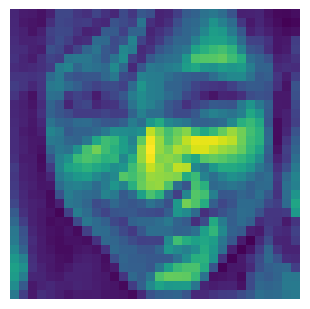

In [35]:
im = generate_real(train_df, 10, (width, height))
print(im.dtype)
plot_image(im, False, dpi=10)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 3s 3s/step


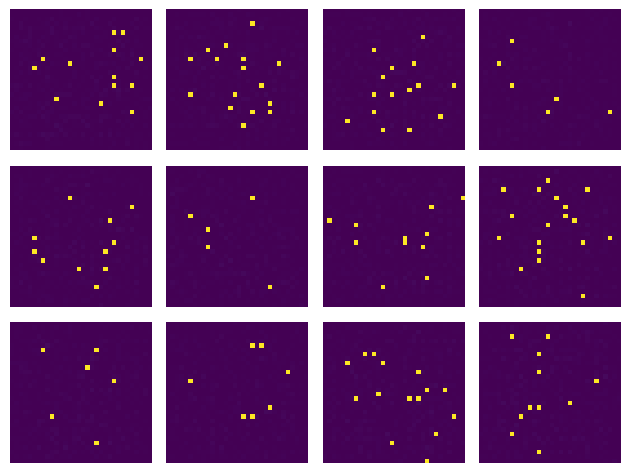

In [36]:
generated_images = generator.predict(np.random.normal(size=(batch_size, latent_dim)))
plot_images(save2file=False, fake=True, samples=12, images=generated_images, dpi=60)

The following block is the train proccess

In [43]:
#Should be a higher number. For learning purposes I have setted this value with a low value.
iterations = 5000

start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    stop = start + batch_size
    real_images = np.zeros((batch_size, width, height, channels), dtype=np.float64)
    
    cont = 0
    for k in range(start, stop):
        print(real_images.shape)
        real_images[cont] = generate_real(train_df, k, (width, height));
        cont += 1
    
    labels_real = np.ones((batch_size, 1))
    labels_fake = np.ones((batch_size, 1))
    
    # Add random noise to the labels - important trick!
    labels_real += 0.05 * np.random.random(labels_real.shape)
    labels_fake += 0.05 * np.random.random(labels_fake.shape)

    # Train the discriminator
    d_loss1 = discriminator.train_on_batch(real_images, labels_real)
    d_loss2 = discriminator.train_on_batch(generated_images, -labels_fake)
    d_loss = 0.5 * (d_loss1 + d_loss2)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.ones((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(train_df) - batch_size:
        start = 0

    if step % 100 == 0:
        print('discriminator loss at step %s:\t %s \t-- adversarial loss at step %s:\t %s' % (step, d_loss, step, a_loss))
        
    # Occasionally save / plot
    if step % 500 == 0:
        showimages = np.concatenate([real_images[:4], generated_images[:8]])
        plot_images(save2file=False, fake=True, samples=12, images=showimages, dpi=60)


1/1 [==============================] - 2s 2s/step
(32, 32, 32, 1)


/var/folders/5n/zdsqqtvs4ml7dvhr54rp68x00000gr/T/ipykernel_17588/1086466033.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = ImageOps.fit(im, size, Image.ANTIALIAS)


ValueError: could not broadcast input array from shape (32,32) into shape (32,32,1)

Finally, we will show some generated images.

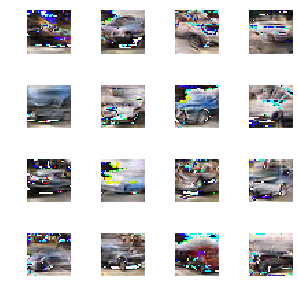

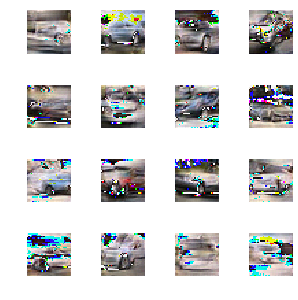

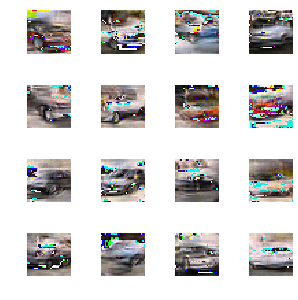

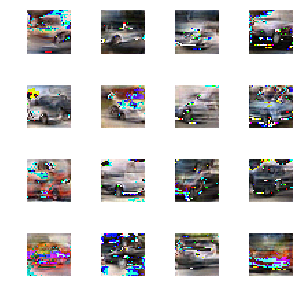

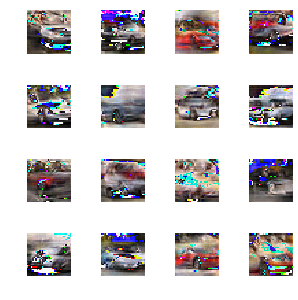

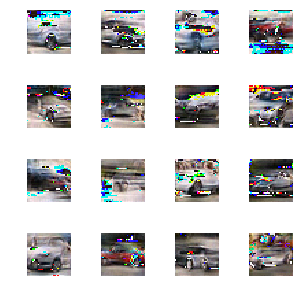

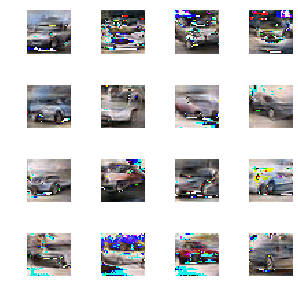

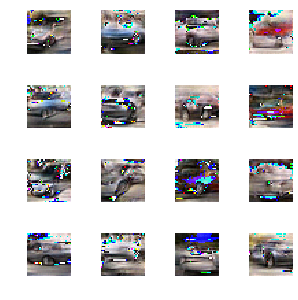

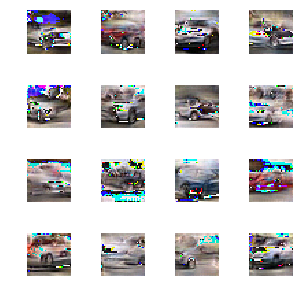

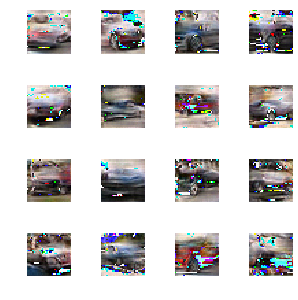

In [18]:
for k in range(0, 10):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    plot_images(save2file=False, fake=True, samples=16, images=generated_images[:16], dpi=120)